# Good and bad color schemes for data visualization
In this notebook, we will generate heatmaps for continuous data, DNA sequence logos and heatmaps, and scatterplots of two groups. For each data modality, we will plot it with color schemes that are and are not color blind friendly.

To visualize all colormaps built into matplotlib, see [this page](https://matplotlib.org/tutorials/colors/colormaps.html).

Package versions:
* Python 3.7.8
* Jupyter lab 2.2.1
* Numpy 1.19.1
* Pandas 1.0.5
* Matplotlib 3.3.0
* Scikit-learn 0.23.1
* [logomaker](https://github.com/jbkinney/logomaker)

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import sklearn.datasets as skdata

import logomaker

# Set up display parameters
mpl.rcParams["axes.titlesize"] = 25
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["figure.figsize"] = (8, 8)
mpl.rcParams["lines.markersize"] = 5
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["font.size"] = 15

## Continuous data: the wine data set
To start, we will column-normalize the data to span from -1 to 1. Then, row-cluster the data using hierarchical clustering with Ward's method.

In [2]:
wine_data = skdata.load_wine(as_frame=True)
data = wine_data["data"]
targets = wine_data["target"]
feature_names = wine_data["feature_names"]

# Min-max normalize the data to span -1 to 1
data = MinMaxScaler(feature_range=(-1, 1)).fit_transform(data)
data = pd.DataFrame(data)

# Row-cluster the data
linkage = hierarchy.linkage(data, method="ward")
# Make the dendrogram, but don't plot it yet
dendrogram = hierarchy.dendrogram(linkage, no_plot=True)
# Row order needs to be inverted to display correctly
row_order = dendrogram["leaves"][::-1]
data = data.iloc[row_order]

Helper functions to make the heatmap with a specified color scheme, and to save a PNG.

In [3]:
def make_heatmap(cmap=None):
    # If no cmap is specified, get the default
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    
    # Make the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(data, aspect="auto", interpolation="none", cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

    # Add a colorbar
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad="2%")
    fig.colorbar(heatmap, cax=cbar_ax)

    # Add dendrogram
    dendro_ax = divider.append_axes("left", size="50%", pad=0)
    hierarchy.dendrogram(linkage, no_labels=True, orientation="left", ax=dendro_ax, color_threshold=0, above_threshold_color="black")
    dendro_ax.axis("off")
    
    return fig, ax

def save_fig(fig, filename):
    fig.tight_layout()
    fig.savefig(filename + ".png")

Bad color scheme: red to green, with black in the middle. This color scheme is so bad that matplotlib doesn't even have it built in, so we need to create it ourselves.

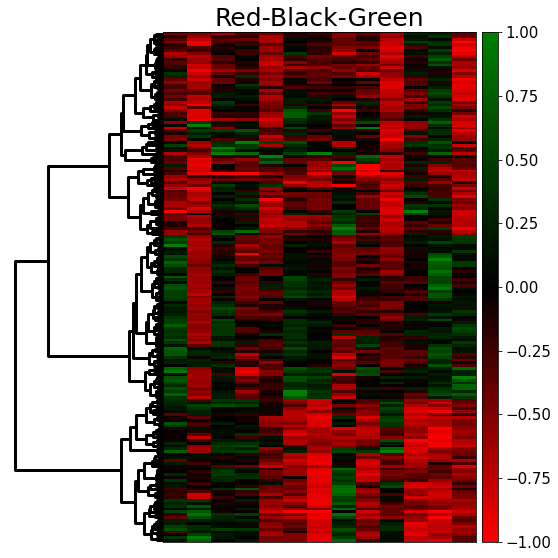

In [4]:
# Create a red-black-green colormap
red = np.array([1, 0, 0, 1])
green = np.array([0, 128/256, 0, 1])
black = np.array([0, 0, 0, 1])
rd_gn_cmap = np.concatenate((np.linspace(red, black, 128), np.flip(np.linspace(green, black, 128), axis=0)))
rd_gn_cmap = ListedColormap(rd_gn_cmap)

fig, ax = make_heatmap(rd_gn_cmap)
ax.set_title("Red-Black-Green")
save_fig(fig, "heatmapRedGreen")

Two good colormaps:
* A diverging colormap (Red-White-Blue) for when the middle value is important.
* A sequential colormap (White to Red) for when the middle value is not important.

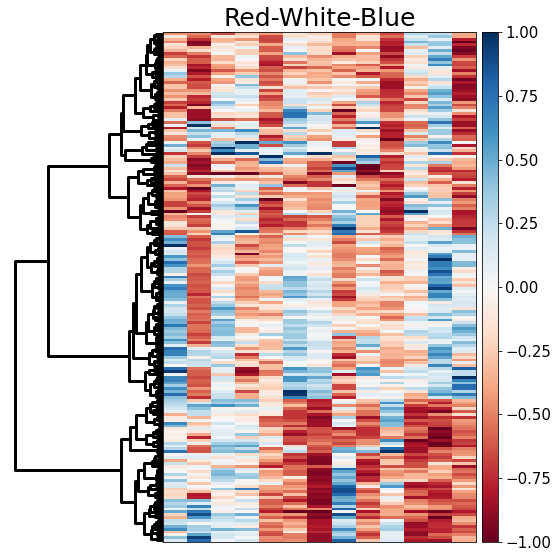

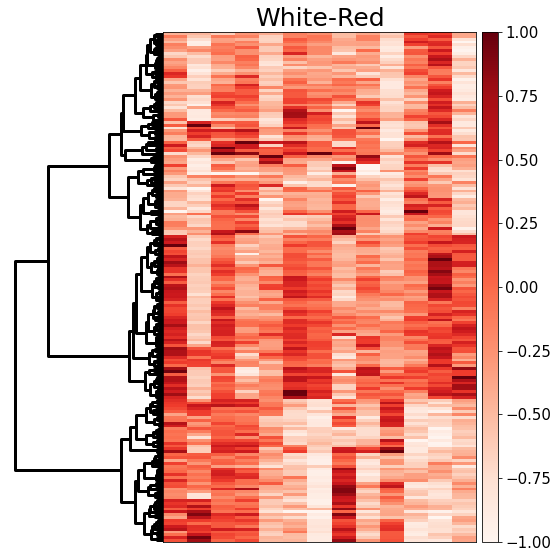

In [5]:
fig, ax = make_heatmap("RdBu")
ax.set_title("Red-White-Blue")
save_fig(fig, "heatmapRedBlue")

fig, ax = make_heatmap("Reds")
ax.set_title("White-Red")
save_fig(fig, "heatmapSequentialRed")

Compare four perceptually uniform colormaps: viridis, plasma, inferno, and magma. Highlighting two sections of the heatmap (boxes) shows why I believe viridis is the best: it shows the most contrast at all parts of the spectrum, not just between the two ends and the middle.

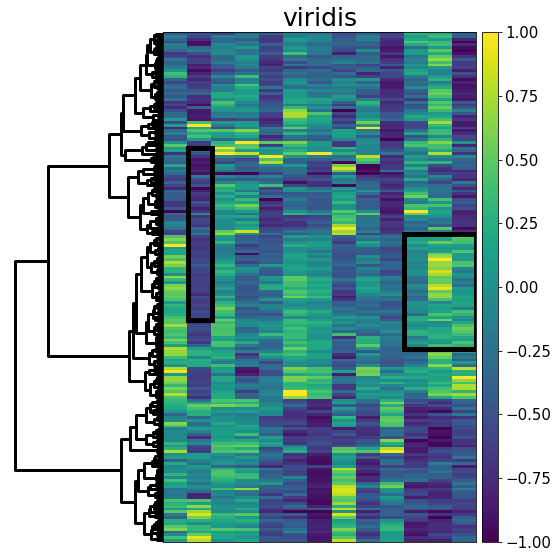

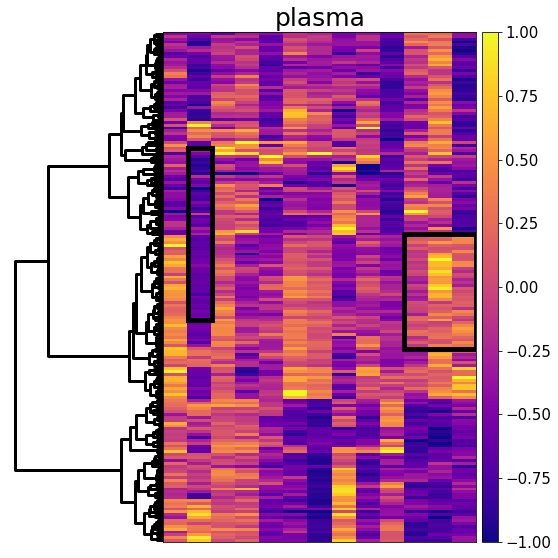

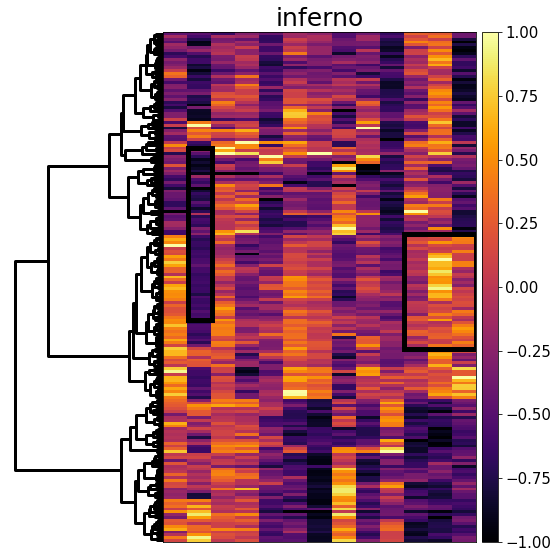

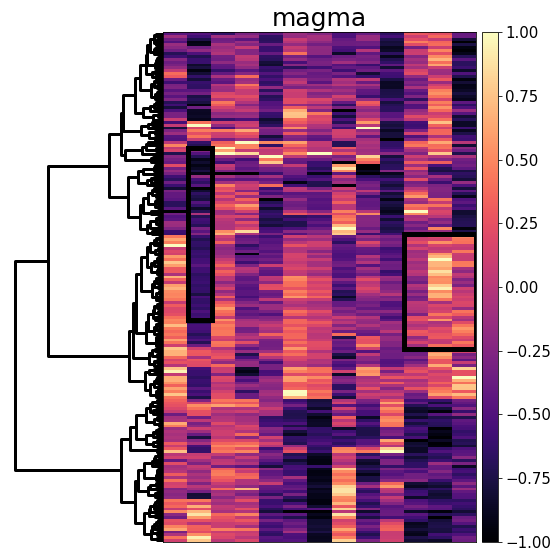

In [6]:
for colors in ["viridis", "plasma", "inferno", "magma"]:
    fig, ax = make_heatmap(colors)
    ax.set_title(colors)
    # Highlight a region that covers a range of the low end of the map
    rect1 = mpatches.Rectangle((0.5, 40), 1, 60, facecolor="none", edgecolor="black", linewidth=5)
    ax.add_patch(rect1)
    # Highlight a region that covers a range of the high end of the map
    rect2 = mpatches.Rectangle((9.5, 70), 3, 40, facecolor="none", edgecolor="black", linewidth=5)
    ax.add_patch(rect2)
    save_fig(fig, "heatmap" + colors.capitalize())

## Representation of DNA
We will use the position weight matrix (PWM) for the mouse transcription factor CRX. We will use the PWM defined by [Lee et al., 2010](https://www.nature.com/articles/gt201077) and first used in the literature by [White et al., 2013](https://www.pnas.org/content/110/29/11952). We will also visualize 100 DNA sequences as a heatmap using [Dataset S1](https://www.pnas.org/highwire/filestream/39288/field_highwire_adjunct_files/1/sd01.txt) from White et al., 2013. In both cases, we will use both the "classic" color scheme and a more color-blind friendly scheme from Gary Stormo's lab.

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


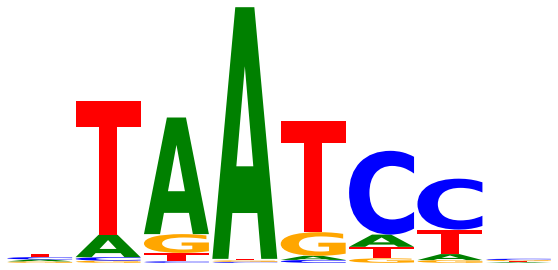

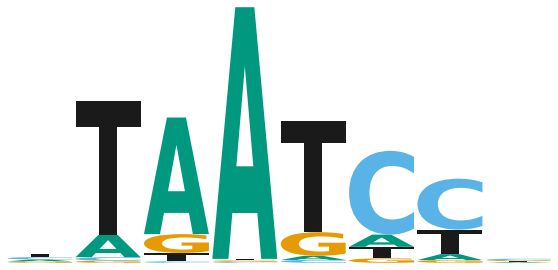

In [7]:
pwm = pd.read_csv("crx.txt", sep=" ", header=None, names=["A", "C", "G", "T"])
pwm = logomaker.transform_matrix(pwm, from_type="probability", to_type="information")

for colors, output in zip(["classic", "colorblind_safe"], ["Default", "Safe"]):
    fig, ax = plt.subplots(figsize=(8, 4))
    logomaker.Logo(pwm, ax=ax, color_scheme=colors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    save_fig(fig, "crxPwm" + output)

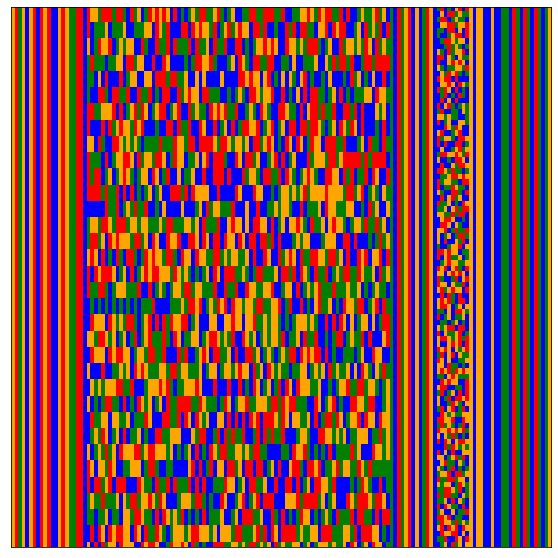

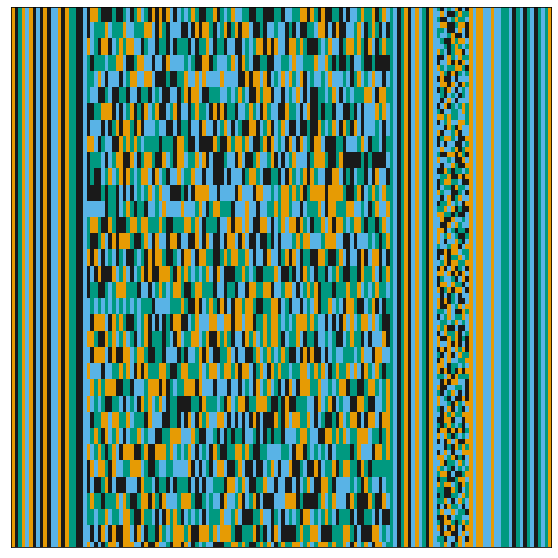

In [8]:
# Read in first 100 lines of the file
sequences = pd.read_csv("sd01.txt", sep="\t", header=None, usecols=[0, 8], index_col=0, nrows=100, squeeze=True)

# Define the two colormaps: classic and colorblind safe
dna_classic = {
    "A": [0, 0.5, 0],
    "C": [0, 0, 1],
    "G": [1, 0.65, 0],
    "T": [1, 0, 0]
}

dna_safe = {
    "A": [0, 153/255, 128/255],
    "C": [89/255, 179/255, 230/255],
    "G": [230/255, 155/255, 4/255],
    "T": [26/255, 26/255, 26/255]
}

# Convert sequences to list of colors
sequences_classic = sequences.apply(lambda x: [dna_classic[i] for i in x])
sequences_safe = sequences.apply(lambda x: [dna_safe[i] for i in x])

# Display the sequences
fig, ax = plt.subplots()
ax.imshow(sequences_classic.values.tolist(), aspect="auto", interpolation="none")
ax.set_xticks([])
ax.set_yticks([])
save_fig(fig, "dnaSequencesClassic")

# Repeat with colorblind space
fig, ax = plt.subplots()
ax.imshow(sequences_safe.values.tolist(), aspect="auto", interpolation="none")
ax.set_xticks([])
ax.set_yticks([])
save_fig(fig, "dnaSequencesSafe")

## Visualizing two categories
Here, we will compare pairs of colors that do and do not work together. These pairs would be used when you are comparing two categories (e.g. case/control) or when displaying microscopy data. For this purpose, we will use the iris dataset. In this dataset, the setosa is linearly separable from versicolor and virginica, so we will treat setosa as one category and versicolor and virginica as the other.

In [9]:
# Helper function to make a scatterplot
def make_scatterplot(x, y, xlabel, ylabel, colors=None):
    # If no colors are specified, make everything black
    if colors is None:
        colors = "black"
        
    fig, ax = plt.subplots()
    ax.scatter(x, y, color=colors)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return fig, ax

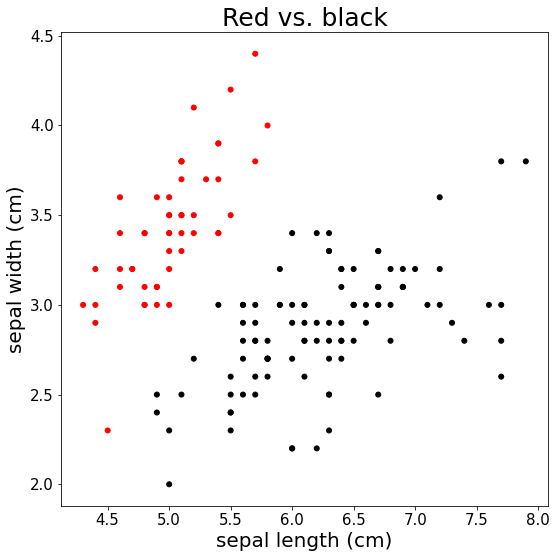

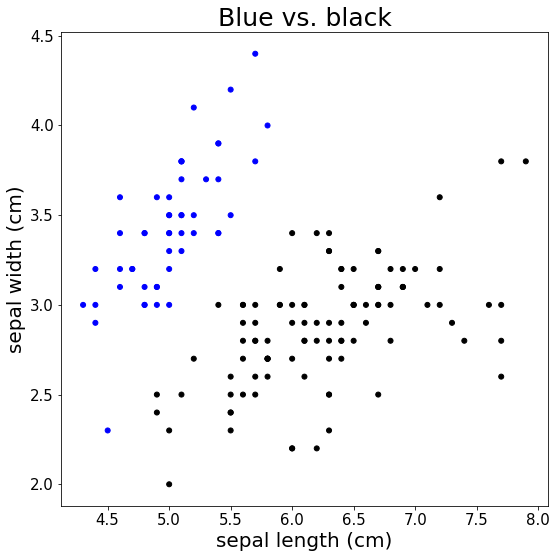

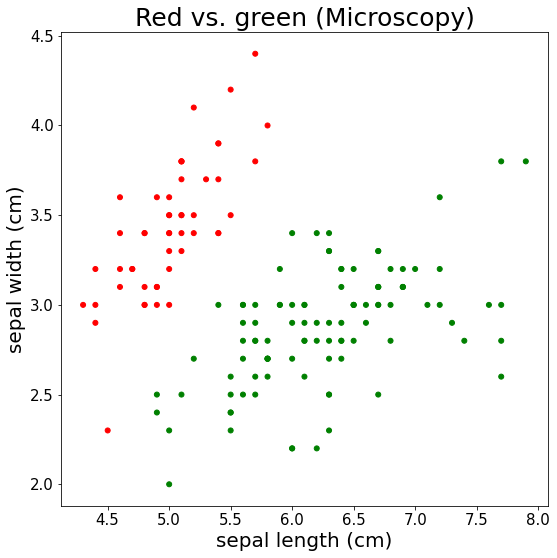

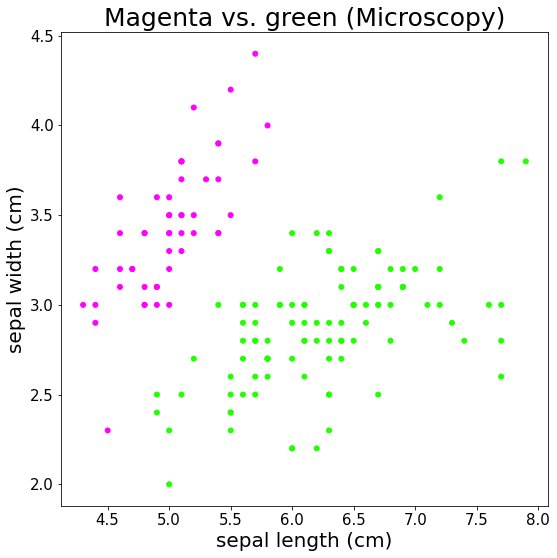

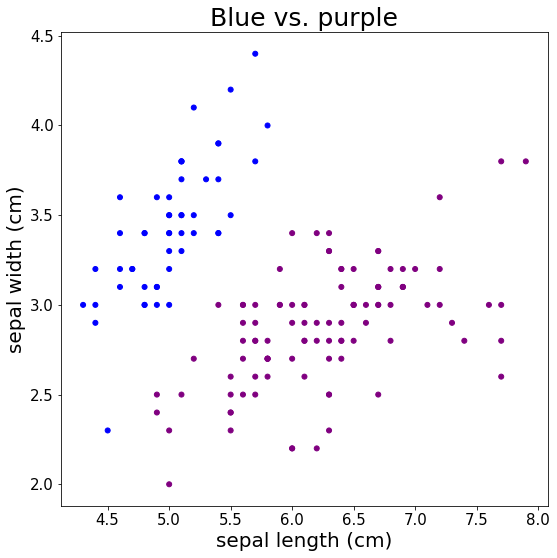

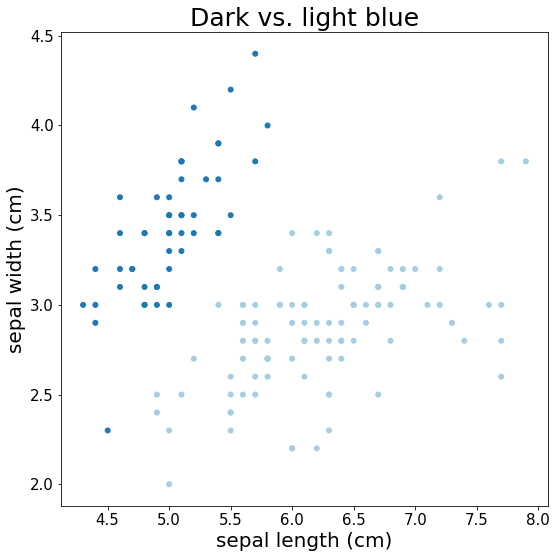

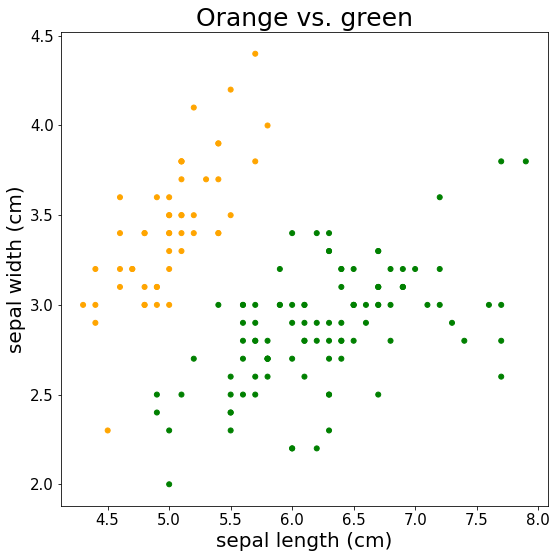

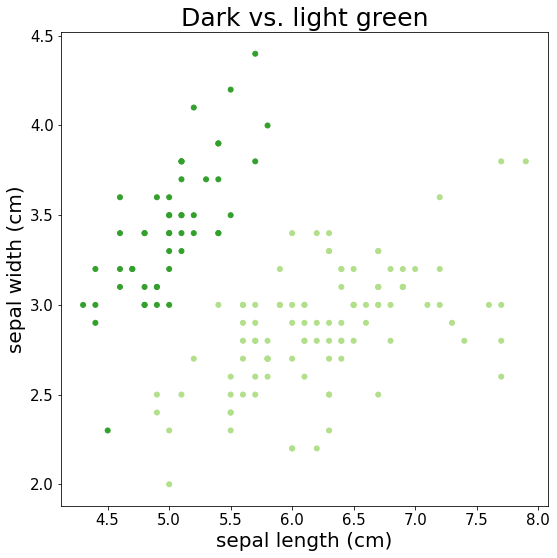

In [10]:
iris_data = skdata.load_iris(as_frame=True)
data = iris_data["data"]
targets = iris_data["target"]
feature_names = iris_data["feature_names"]
# Target 0 is setosa, which is linearly separable from target 1 (versicolor) and target 2 (virginica)

xlabel = feature_names[0]
ylabel = feature_names[1]
x = data[xlabel]
y = data[ylabel]

colors_title_output = [
    (["red" if i == 0 else "black" for i in targets], "Red vs. black", "RedBlack"), # Bad
    (["blue" if i == 0 else "black" for i in targets], "Blue vs. black", "BlueBlack"), # Good
    (["red" if i == 0 else "green" for i in targets], "Red vs. green (Microscopy)", "RedGreenBad"), # Bad
    (["#ff00ff" if i == 0 else "#22ff00" for i in targets], "Magenta vs. green (Microscopy)", "MagentaGreen"), # Good
    (["blue" if i == 0 else "purple" for i in targets], "Blue vs. purple", "BluePurple"), # Bad
    (["#1f78b4" if i == 0 else "#a6cee3" for i in targets], "Dark vs. light blue", "BlueDarkLight"), # Good
    (["orange" if i == 0 else "green" for i in targets], "Orange vs. green", "OrangeGreen"), # Bad
    (["#33a02c" if i == 0 else "#b2df8a" for i in targets], "Dark vs. light green", "GreenDarkLight") # Good
]
for colors, title, output in colors_title_output:
    fig, ax = make_scatterplot(x, y, xlabel, ylabel, colors)
    ax.set_title(title)
    save_fig(fig, "irisScatter" + output)